In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling1D, MaxPool1D, Dropout,Conv1D,MaxPooling2D
from scipy import signal
from sklearn.metrics import roc_curve

import sys  
sys.path.insert(0, '../src')
import HAR_functions

from HAR_functions import *

%load_ext autoreload
%autoreload 2

# read in data

In [2]:
train_raw,meta = arff.loadarff('../data/Epilepsy_TRAIN.arff')
train_pd = pd.DataFrame(train_raw)

pd.DataFrame(train_raw)

,relationalAtt,activity
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY'
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY'
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY'
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY'
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY'
...,...,...
132,"[[0.45, -0.28, 0.28, 1.33, 1.01, 0.06, -0.11, ...",b'SAWING'
133,"[[0.24, -0.79, -0.65, 0.07, 1.5, 1.55, 0.94, 0...",b'SAWING'
134,"[[1.16, -0.02, -1.04, -0.81, 0.36, 1.69, 0.93,...",b'SAWING'
135,"[[-0.74, -0.14, 0.12, -0.08, -0.78, -1.42, -1....",b'SAWING'


## Making it Binary
**adding a column that is 1 if seizure, and 0 if not seizure**

In [3]:
train_pd['label_binary'] = np.where(train_pd['activity']==b'EPILEPSY',1,0)

train_pd

,relationalAtt,activity,label_binary
0,"[[0.35, 0.4, 0.44, 0.47, 0.48, 0.47, 0.44, 0.4...",b'EPILEPSY',1
1,"[[-0.91, -0.92, -0.95, -0.95, -0.95, -0.94, -0...",b'EPILEPSY',1
2,"[[0.32, 0.71, 0.7, 0.75, 0.88, 0.58, 1.34, 0.6...",b'EPILEPSY',1
3,"[[-0.68, -0.36, -0.13, -0.38, -0.49, -0.48, -0...",b'EPILEPSY',1
4,"[[0.34, 0.53, 0.58, 0.61, 0.64, 0.63, 0.44, 0....",b'EPILEPSY',1
...,...,...,...
132,"[[0.45, -0.28, 0.28, 1.33, 1.01, 0.06, -0.11, ...",b'SAWING',0
133,"[[0.24, -0.79, -0.65, 0.07, 1.5, 1.55, 0.94, 0...",b'SAWING',0
134,"[[1.16, -0.02, -1.04, -0.81, 0.36, 1.69, 0.93,...",b'SAWING',0
135,"[[-0.74, -0.14, 0.12, -0.08, -0.78, -1.42, -1....",b'SAWING',0


In [10]:
#percent positive samples in train set
len(train_pd[train_pd['label_binary']==1])/len(train_pd)

0.24817518248175183

if classes a severly imbalence, the model may not have enough information/example of the minority to be able to acuratly distigush the minority class. In this case I do not believe that 25% is too sever and i will proceed with out over sampleing

## convert whole train set to shperical coordinants

In [6]:
# going to convert to shereical and only take rho and phi becasue they are inchanged when watch is wor a different angle

rho_phi = df_to_rho_phi(train_pd)

../src/HAR_functions.py:39: RuntimeWarning: divide by zero encountered in true_divide
  return np.arctan(y/x)


In [8]:
rho_phi.shape # 137 sample with 206 time steps

(137, 206, 2)

In [10]:
#check for nans since i got that pink error
sum_ = np.sum(rho_phi)
has_nan = np.isnan(sum_)
has_nan

False

## Visualize the data 
checking out what the data looks like:

In [11]:
ep = rho_phi[train_pd['activity']==b'EPILEPSY']
saw = rho_phi[train_pd['activity']==b'SAWING']
walk = rho_phi[train_pd['activity']==b'WALKING']
run = rho_phi[train_pd['activity']==b'RUNNING']

''

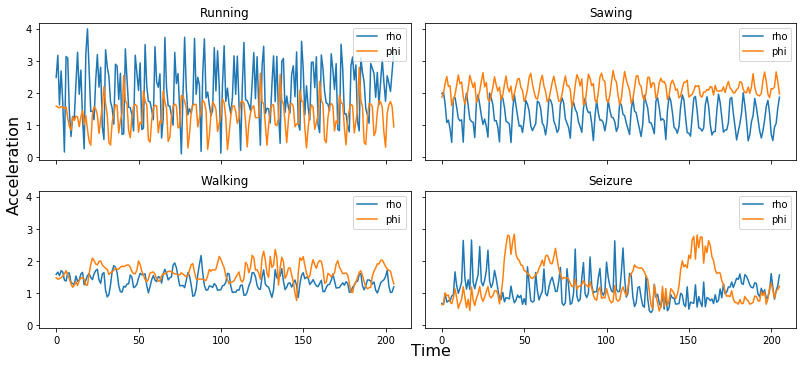

In [12]:
fig, axs = plt.subplots(2,2,figsize=(11,5),sharey=True,sharex=True)

axs[0][0].plot(run[0][:,0], label="rho")
axs[0][0].plot(run[0][:,1], label="phi")
axs[0][0].legend()
axs[0][0].set_title('Running')
axs[1][0].plot(walk[0][:,0], label="rho")
axs[1][0].plot(walk[0][:,1],label="phi")
axs[1][0].legend()
axs[1][0].set_title('Walking')
axs[0][1].plot(saw[0][:,0], label="rho")
axs[0][1].plot(saw[0][:,1], label="phi")
axs[0][1].legend()
axs[0][1].set_title('Sawing')
axs[1][1].plot(ep[0][:,0], label="rho")
axs[1][1].plot(ep[0][:,1], label="phi")
axs[1][1].legend()
axs[1][1].set_title('Seizure')

fig.text(.5,0,'Time',size=16)
fig.text(-.01,.4,'Acceleration',rotation=90,size=16)
plt.tight_layout()

;

In [13]:
#making sure shape is good for nn
rho_phi_3d_2 = rho_phi.reshape(137,206,2)

In [14]:
#shape of single sample
rho_phi_3d_2[0].shape

(206, 2)

## Splitting the data so I can train on a validation set of data and leave a hold out for final evaluation

In [19]:
# grabbing target values
y = train_pd['label_binary'].values

In [20]:
# splitting the data at a 75/25 train/validation ratio
X_train_rhophi, X_vali_rhophi, y_train_rhophi, y_vali_rhophi = train_test_split(rho_phi_3d_2, y, test_size = 0.25, random_state = 666)

In [21]:
X_train_rhophi.shape

(102, 206, 2)

# MODEL 1 : 1d CNN

convolution is useful when the order of the features matters. my features are time steps so order matters. Also, CNNs are good at picking up patterns. I beleivie this could be useful for my data.

In [290]:
model1 = Sequential()
# genraly you want one filter per feature in a cnn, but since my features are time steps i went smaller (and for fitting time)
# alot of time in 2d image kernal size is 2 by 2. I did not want to choose 2 for my data because how two time steps relate to each other doesnt mean much but with three you can see if there is trend up or down
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(206,2)))
# drop out for regularization (prevent over fitting)
model1.add(Dropout(0.5))
# I chose max pooling over average becasue experimentaly it seems to work better
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(Dropout(0.5))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
#relu also chosen for it perfomance in research experiments
model1.add(Dense(100, activation='relu'))
model1.add(Dense(50, activation='relu'))
#sigmoid activation because I need my  output to be a probablility (between 0 and 1)
# one neuron output becasue my target is binary
model1.add(Dense(1, activation='sigmoid'))

In [498]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 204, 64)           448       
_________________________________________________________________
dropout_12 (Dropout)         (None, 204, 64)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 102, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           12352     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)             

In [23]:
metrics1 = ['accuracy','TruePositives', 'TrueNegatives','FalsePositives','FalseNegatives','Precision','Recall']

#i chose binary-crossentropy as my loss function becasue my output is binary (two classes)
#I shose adam as my optimizer for its knows memory and computational efficientcies. its faster
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

batch_size=32 # keeps my modle from crashing by feeding in data in chunks, not all at the same go

In [292]:
tensorboard = TensorBoard(log_dir='./logs8', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
model1_hist = model1.fit(X_train_rhophi, y_train_rhophi, batch_size=batch_size, epochs=100, 
          validation_data = (X_vali_rhophi,y_vali_rhophi), callbacks = [tensorboard])

Epoch 1/100
4/4 [==============================] - 2s 424ms/step - loss: 0.7718 - accuracy: 0.5686 - true_positives: 5.0000 - true_negatives: 53.0000 - false_positives: 26.0000 - false_negatives: 18.0000 - precision: 0.1613 - recall: 0.2174 - val_loss: 0.6290 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 30ms/step - loss: 0.5731 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6144 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 64ms

Epoch 17/100
4/4 [==============================] - 0s 53ms/step - loss: 0.4666 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5456 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/100
4/4 [==============================] - 0s 32ms/step - loss: 0.4710 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5711 - val_accuracy: 0.8000 - val_true_positives: 4.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 7.0000 - val_precision: 1.0000 - val_recall: 0.3636
Epoch 19/100
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 51ms/step - loss: 0.0498 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 0.2354 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 54/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0418 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 0.2477 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 55/100
4/4 [==============================] - 0s 62ms/step - loss: 0.0539 - accuracy: 0.9804 - true_positiv

4/4 [==============================] - 0s 67ms/step - loss: 0.0153 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 0.2700 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 90/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0039 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2736 - val_accuracy: 0.8857 - val_true_positives: 9.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 2.0000 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 91/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0102 - accuracy: 1.0000 - true_pos

**becasue I have that class imbalance I am chooing to keep my eye on recall --> What proportion of actual positives was identified correctly**

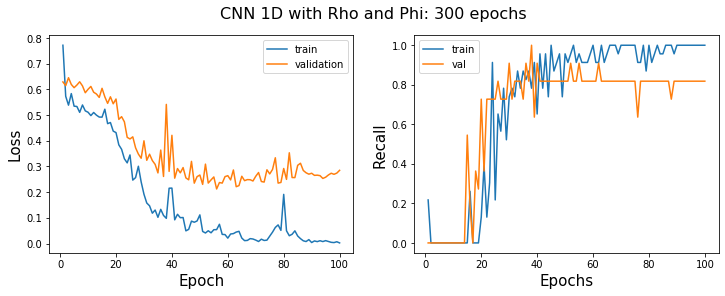

In [446]:
lr_plot(model1_hist,'CNN 1D with Rho and Phi: 300 epochs','lr_plot_model1_rhophi_300epochs3.png')

In [448]:
model1.save('../models/CNN1d.h5')

# 2d CNN : spectrograph

Apon reading a scientific journal on HAR, I learned about a techneque where samples were tranformed into 2d images by  taking the fourier transformation of the signal at sliding windows of time. So, I decided to try this out

### lets look at an example of the transormation of a sample

In [65]:
#rate = 16 

freqs, times, Sxrho = signal.spectrogram(X_train_rhophi[1][:,0], nperseg=20,noverlap=2) # sperseg size of window
freqs, times, Sxphi = signal.spectrogram(X_train_rhophi[1][:,1], nperseg=20,noverlap=2) 

''

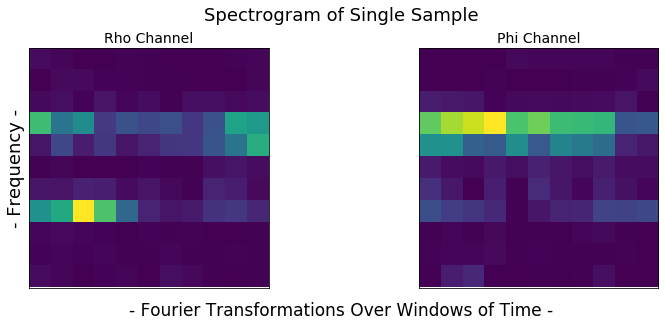

In [134]:
fig, axs = plt.subplots(1,2,figsize=(12,5),sharex=True)
axs[0].imshow(Sxrho)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_ylabel('- Frequency -',size=18)
axs[0].set_title('Rho Channel',size=14)

axs[1].imshow(Sxphi)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Phi Channel',size=14)
                  
fig.text(0.5, 0.07, '- Fourier Transformations Over Windows of Time -', ha='center',size=17)
fig.text(0.5, .89, 'Spectrogram of Single Sample', ha='center',size=18)


plt.tight_layout(pad=5)
#plt.savefig('../images/spectrogram_sample2.png')
;

**the shape i want is (102,11,11,2) for train and (35,11,11,2)**

In [27]:
X_train_rhophi.shape

(102, 206, 2)

In [367]:
X_vali_rhophi.shape

(35, 206, 2)

In [370]:
freqs, times, Sxrho = signal.spectrogram(X_train_rhophi[1][:,0], nperseg=20,noverlap=2) 

In [371]:
freqs, times, Sxphi = signal.spectrogram(X_train_rhophi[1][:,1], nperseg=20,noverlap=2) 

In [375]:
np.dstack((Sxrho,Sxphi)).shape #this with 

(11, 11, 2)

## convert time series df to df of spectrogram images

In [31]:

X_train_spec = ts_df_to_spectrogram(X_train_rhophi)

X_vali_spec = ts_df_to_spectrogram(X_vali_rhophi)

In [518]:
model2 = Sequential()
model2.add(Conv2D(filters=20, kernel_size=2, activation='relu', input_shape=(11,11,2)))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(filters=20, kernel_size=2, activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [484]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 9, 9, 64)          1216      
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)               

In [519]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

In [520]:
tensorboard = TensorBoard(log_dir='./logs8', histogram_freq=2, batch_size=32, write_graph=True, write_grads=True, write_images=True)
model2_hist = model2.fit(X_train_spec, y_train_rhophi, batch_size=batch_size, epochs=300, 
          validation_data = (X_vali_spec,y_vali_rhophi), callbacks = [tensorboard])

Epoch 1/300
4/4 [==============================] - 1s 179ms/step - loss: 0.5835 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.6273 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 0.5266 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.6244 - val_accuracy: 0.7143 - val_true_positives: 1.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 10.0000 - val_precision: 1.0000 - val_recall: 0.0909
Epoch 3/300
4/4 [==============================] - 0s 11ms/step - loss: 0.4786 

Epoch 18/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1768 - accuracy: 0.9412 - true_positives: 18.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 5.0000 - precision: 0.9474 - recall: 0.7826 - val_loss: 0.6695 - val_accuracy: 0.6857 - val_true_positives: 3.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 8.0000 - val_precision: 0.5000 - val_recall: 0.2727
Epoch 19/300
4/4 [==============================] - 0s 13ms/step - loss: 0.2414 - accuracy: 0.9118 - true_positives: 17.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 6.0000 - precision: 0.8500 - recall: 0.7391 - val_loss: 0.6742 - val_accuracy: 0.6571 - val_true_positives: 3.0000 - val_true_negatives: 20.0000 - val_false_positives: 4.0000 - val_false_negatives: 8.0000 - val_precision: 0.4286 - val_recall: 0.2727
Epoch 20/300
4/4 [==============================] - 0s 11ms/step - loss: 0.1516 - accuracy: 0.9412 - true_po

4/4 [==============================] - 0s 8ms/step - loss: 0.1620 - accuracy: 0.9314 - true_positives: 22.0000 - true_negatives: 73.0000 - false_positives: 6.0000 - false_negatives: 1.0000 - precision: 0.7857 - recall: 0.9565 - val_loss: 0.8199 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 55/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1623 - accuracy: 0.9216 - true_positives: 20.0000 - true_negatives: 74.0000 - false_positives: 5.0000 - false_negatives: 3.0000 - precision: 0.8000 - recall: 0.8696 - val_loss: 0.7961 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 56/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0823 - accuracy: 0.9902 - true_positives: 22.000

4/4 [==============================] - 0s 7ms/step - loss: 0.0922 - accuracy: 0.9510 - true_positives: 22.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 1.0000 - precision: 0.8462 - recall: 0.9565 - val_loss: 1.1239 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 91/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1308 - accuracy: 0.9510 - true_positives: 19.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 4.0000 - precision: 0.9500 - recall: 0.8261 - val_loss: 1.1213 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 92/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0954 - accuracy: 0.9706 - true_positives: 22.000

4/4 [==============================] - 0s 10ms/step - loss: 0.0648 - accuracy: 0.9706 - true_positives: 20.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 3.0000 - precision: 1.0000 - recall: 0.8696 - val_loss: 1.3485 - val_accuracy: 0.6000 - val_true_positives: 3.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 8.0000 - val_precision: 0.3333 - val_recall: 0.2727
Epoch 127/300
4/4 [==============================] - 0s 10ms/step - loss: 0.1474 - accuracy: 0.9804 - true_positives: 21.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000 - precision: 1.0000 - recall: 0.9130 - val_loss: 1.2813 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 128/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0781 - accuracy: 0.9608 - true_positi

4/4 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.9706 - true_positives: 22.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 1.0000 - precision: 0.9167 - recall: 0.9565 - val_loss: 1.6193 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 163/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0286 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 1.6728 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 164/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.9804 - true_positives: 

4/4 [==============================] - 0s 8ms/step - loss: 0.0243 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 1.8046 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 199/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0390 - accuracy: 0.9804 - true_positives: 22.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 1.0000 - precision: 0.9565 - recall: 0.9565 - val_loss: 1.8158 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 200/300
4/4 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9902 - true_positives: 

4/4 [==============================] - 0s 7ms/step - loss: 0.0086 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0337 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 235/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0528 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 236/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0143 - accuracy: 1.0000 - true_

4/4 [==============================] - 0s 8ms/step - loss: 0.0106 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1259 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 271/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0257 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 2.1486 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 272/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0198 - accuracy: 0.9902 - true_pos

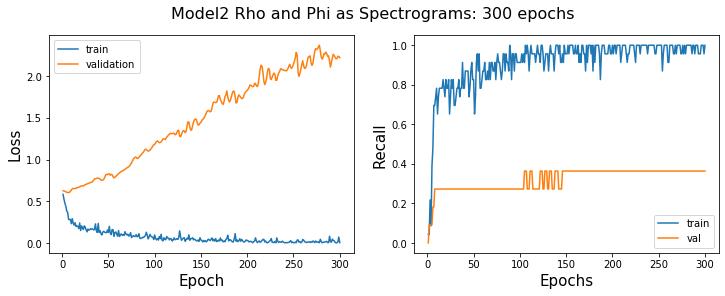

In [521]:
lr_plot(model2_hist,'Model2 Rho and Phi as Spectrograms: 300 epochs','model2_specs_300_3.png')

lets try an make this better

**Lets go deeper**<br>
- the validation loss seems to be growing with that last architecture. I would like to give my model more learnable parameters (making it deeper) to see if this will help it start to learn.<br>
- Becasue my images are so small,and pooling makes your feature maps smaller and smaller, I am only going to use max pooling one time at the end and not with every layer. I hope to keep more information available in my feature maps.

In [48]:
model_deeper1 = Sequential()
model_deeper1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(11,11,2)))
#model_deeper1.add(MaxPooling2D(pool_size=(2,2)))
model_deeper1.add(Dropout(0.5))
model_deeper1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
#model_deeper1.add(MaxPooling2D(pool_size=(2,2)))
model_deeper1.add(Dropout(0.5))
model_deeper1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
#model_deeper1.add(MaxPooling2D(pool_size=(2,2)))
model_deeper1.add(Dropout(0.5))
model_deeper1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_deeper1.add(MaxPooling2D(pool_size=(2,2)))
model_deeper1.add(Dropout(0.5))
model_deeper1.add(Flatten())
#mode_deeper1.add(Dense(, activation='relu'))
model_deeper1.add(Dense(100, activation='relu'))
model_deeper1.add(Dense(1, activation='sigmoid'))

In [49]:
model_deeper1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 9, 9, 16)          304       
_________________________________________________________________
dropout_21 (Dropout)         (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 5, 5, 64)          18496     
_________________________________________________________________
dropout_23 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 3, 128)       

**this doubled the amount of trainable parameter lets see if this helped.**

In [52]:
model_deeper1.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics1)

In [54]:
tensorboard = TensorBoard(log_dir='./logs_deeper1', histogram_freq=2, batch_size=32, write_graph=True, write_grads=True, write_images=True)
model_deeper1_hist = model_deeper1.fit(X_train_spec, y_train_rhophi, batch_size=32, epochs=300, 
          validation_data = (X_vali_spec,y_vali_rhophi), callbacks = [tensorboard])

Epoch 1/300
1/4 [======>.......................] - ETA: 0s - loss: 0.6328 - accuracy: 0.7812 - true_positives: 0.0000e+00 - true_negatives: 25.0000 - false_positives: 0.0000e+00 - false_negatives: 7.0000 - precision: 0.0000e+00 - recall: 0.0000e+00WARNING:tensorflow:From /home/rachel/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4/4 [==============================] - 1s 172ms/step - loss: 0.6519 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.6311 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2

4/4 [==============================] - 0s 11ms/step - loss: 0.1747 - accuracy: 0.9314 - true_positives: 20.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 3.0000 - precision: 0.8333 - recall: 0.8696 - val_loss: 1.2977 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 36/300
4/4 [==============================] - 0s 8ms/step - loss: 0.1571 - accuracy: 0.9118 - true_positives: 17.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 6.0000 - precision: 0.8500 - recall: 0.7391 - val_loss: 1.3811 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 37/300
4/4 [==============================] - 0s 26ms/step - loss: 0.1599 - accuracy: 0.9020 - true_positives: 14.00

4/4 [==============================] - 0s 18ms/step - loss: 0.1477 - accuracy: 0.9412 - true_positives: 23.0000 - true_negatives: 73.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00 - precision: 0.7931 - recall: 1.0000 - val_loss: 1.7293 - val_accuracy: 0.5714 - val_true_positives: 5.0000 - val_true_negatives: 15.0000 - val_false_positives: 9.0000 - val_false_negatives: 6.0000 - val_precision: 0.3571 - val_recall: 0.4545
Epoch 72/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0951 - accuracy: 0.9706 - true_positives: 23.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00 - precision: 0.8846 - recall: 1.0000 - val_loss: 1.8471 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 73/300
4/4 [==============================] - 0s 13ms/step - loss: 0.1311 - accuracy: 0.9314 - true_positiv

4/4 [==============================] - 0s 12ms/step - loss: 0.1661 - accuracy: 0.9608 - true_positives: 22.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 1.0000 - precision: 0.8800 - recall: 0.9565 - val_loss: 2.3122 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 108/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0579 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 2.2227 - val_accuracy: 0.6000 - val_true_positives: 4.0000 - val_true_negatives: 17.0000 - val_false_positives: 7.0000 - val_false_negatives: 7.0000 - val_precision: 0.3636 - val_recall: 0.3636
Epoch 109/300
4/4 [==============================] - 0s 11ms/step - loss: 0.1106 - accuracy: 0.9510 - true_positives:

Epoch 125/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0798 - accuracy: 0.9706 - true_positives: 22.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 1.0000 - precision: 0.9167 - recall: 0.9565 - val_loss: 2.1696 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 126/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0373 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 2.1612 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 127/300
4/4 [==============================] - 0s 31ms/step - loss: 0.0465 - accuracy: 0.9902 - 

4/4 [==============================] - 0s 12ms/step - loss: 0.0131 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.7678 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 162/300
4/4 [==============================] - 0s 9ms/step - loss: 0.0252 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 3.8346 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 163/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0388 - accuracy: 0.9902 - true_po

4/4 [==============================] - 0s 12ms/step - loss: 0.0186 - accuracy: 0.9902 - true_positives: 23.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00 - precision: 0.9583 - recall: 1.0000 - val_loss: 4.5258 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 198/300
4/4 [==============================] - 0s 8ms/step - loss: 0.0279 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 4.5722 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 199/300
4/4 [==============================] - 0s 11ms/step - loss: 0.0298 - accuracy: 0.9902 - true_positi

4/4 [==============================] - 0s 13ms/step - loss: 0.2844 - accuracy: 0.9706 - true_positives: 20.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 3.0000 - precision: 1.0000 - recall: 0.8696 - val_loss: 4.6113 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 234/300
4/4 [==============================] - 0s 10ms/step - loss: 0.0140 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.3495 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 235/300
4/4 [==============================] - 0s 13ms/step - loss: 0.0139 - accuracy: 1.0000 - true_p

4/4 [==============================] - 0s 12ms/step - loss: 0.0163 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 5.4060 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 270/300
4/4 [==============================] - 0s 8ms/step - loss: 0.3348 - accuracy: 0.9510 - true_positives: 18.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 5.0000 - precision: 1.0000 - recall: 0.7826 - val_loss: 4.9119 - val_accuracy: 0.6286 - val_true_positives: 4.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 7.0000 - val_precision: 0.4000 - val_recall: 0.3636
Epoch 271/300
4/4 [==============================] - 0s 12ms/step - loss: 0.0251 - accuracy: 0.9804 - true_positi

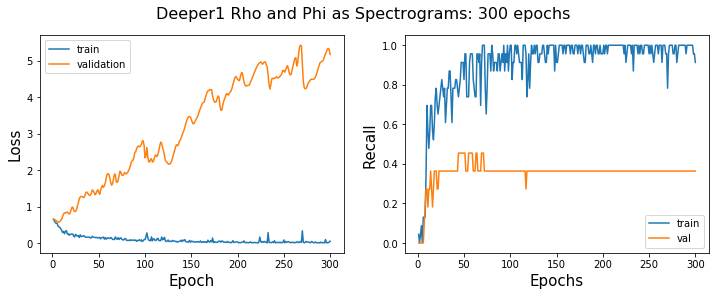

In [55]:
lr_plot(model_deeper1_hist,'Deeper1 Rho and Phi as Spectrograms: 300 epochs','model_deeper1_specs_300.png')

the loss side of this has become worse. maybe going deeper is not the direction I want to go. with out being able to look at the archetecture and data transformation into 2d from  Jiang and Yin (2015) I dont know how to make this better with out impirically tring differnt architecture. The problem may be that my spectrograms are so small that I cant get the resolution high enough for the the network to see patterns. 

could this be a vanishing gradient problem from going too deep? I am already useing relu activation function between my layers which can help with this. 

# LSTM

I would like to try out a LSTM architecture becasue it is very often used to classify time series data. it also is a version of an RNN that is less likeing to have an exploding gradient which can prevent the NN from learning. it is better then a simple RNN becasue it can store longer memory of past time steps longer. 

In [275]:

model_LSTM1 = keras.Sequential()
model_LSTM1.add(keras.layers.LSTM(32, input_shape=(206, 2), return_sequences=True))
model_LSTM1.add(keras.layers.LSTM(32, return_sequences=False))
model_LSTM1.add(keras.layers.Dense(1, activation='sigmoid'))
model_LSTM1.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=metrics1)

In [277]:
model_LSTM1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 206, 32)           4480      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [25]:
X_train_rhophi.shape, X_vali_rhophi.shape, y_train_rhophi.shape, y_vali_rhophi.shape

((102, 206, 2), (35, 206, 2), (102,), (35,))

In [147]:
LSTM1_hist = model_LSTM1.fit(X_train_rhophi,y_train_rhophi, epochs=300, validation_data=(X_vali_rhophi,y_vali_rhophi))

Epoch 1/300
4/4 [==============================] - 1s 347ms/step - loss: 0.7041 - accuracy: 0.4020 - true_positives: 12.0000 - true_negatives: 29.0000 - false_positives: 50.0000 - false_negatives: 11.0000 - precision: 0.1935 - recall: 0.5217 - val_loss: 0.6462 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 88ms/step - loss: 0.5958 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6278 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 85m

4/4 [==============================] - 0s 83ms/step - loss: 0.5313 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6477 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/300
4/4 [==============================] - 0s 82ms/step - loss: 0.5310 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6472 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/300
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 89ms/step - loss: 0.5260 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6716 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/300
4/4 [==============================] - 0s 87ms/step - loss: 0.5281 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6818 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/300
4/4 [==============================] - 0s 

Epoch 104/300
4/4 [==============================] - 0s 107ms/step - loss: 0.5326 - accuracy: 0.7941 - true_positives: 10.0000 - true_negatives: 71.0000 - false_positives: 8.0000 - false_negatives: 13.0000 - precision: 0.5556 - recall: 0.4348 - val_loss: 0.7000 - val_accuracy: 0.6571 - val_true_positives: 1.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 10.0000 - val_precision: 0.3333 - val_recall: 0.0909
Epoch 105/300
4/4 [==============================] - 0s 94ms/step - loss: 0.5045 - accuracy: 0.7941 - true_positives: 5.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 18.0000 - precision: 0.6250 - recall: 0.2174 - val_loss: 0.6738 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 106/300
4/4 [==============================] - 0s 91ms/step - loss: 0.4919 - accuracy: 0.7843 - 

4/4 [==============================] - 0s 90ms/step - loss: 0.4369 - accuracy: 0.8333 - true_positives: 10.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 13.0000 - precision: 0.7143 - recall: 0.4348 - val_loss: 0.4867 - val_accuracy: 0.7143 - val_true_positives: 3.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 8.0000 - val_precision: 0.6000 - val_recall: 0.2727
Epoch 141/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4292 - accuracy: 0.8333 - true_positives: 9.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 14.0000 - precision: 0.7500 - recall: 0.3913 - val_loss: 0.4354 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 142/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4146 - accuracy: 0.8235 - true_positives: 

Epoch 176/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4695 - accuracy: 0.8137 - true_positives: 4.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 19.0000 - precision: 1.0000 - recall: 0.1739 - val_loss: 0.7075 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 177/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4652 - accuracy: 0.8137 - true_positives: 4.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 19.0000 - precision: 1.0000 - recall: 0.1739 - val_loss: 0.7000 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 178/300
4/4 [==============================] - 0s 87ms/step - loss

Epoch 194/300
4/4 [==============================] - 0s 90ms/step - loss: 0.4134 - accuracy: 0.8431 - true_positives: 7.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 16.0000 - precision: 1.0000 - recall: 0.3043 - val_loss: 0.6893 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 195/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4039 - accuracy: 0.8431 - true_positives: 8.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 15.0000 - precision: 0.8889 - recall: 0.3478 - val_loss: 0.6792 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 196/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4029 - accuracy: 0.8431 -

4/4 [==============================] - 0s 87ms/step - loss: 0.5026 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6099 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 213/300
4/4 [==============================] - 0s 90ms/step - loss: 0.5009 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5954 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 214/300
4/4 [==============================] - 0

Epoch 247/300
4/4 [==============================] - 0s 87ms/step - loss: 0.4548 - accuracy: 0.8235 - true_positives: 6.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 17.0000 - precision: 0.8571 - recall: 0.2609 - val_loss: 0.6649 - val_accuracy: 0.6286 - val_true_positives: 0.0000e+00 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 248/300
4/4 [==============================] - 0s 89ms/step - loss: 0.4455 - accuracy: 0.8235 - true_positives: 6.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 17.0000 - precision: 0.8571 - recall: 0.2609 - val_loss: 0.6768 - val_accuracy: 0.6286 - val_true_positives: 0.0000e+00 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 249/300
4/4 [==============================] - 0s 87ms/step - loss: 0.4340

Epoch 265/300
4/4 [==============================] - 0s 89ms/step - loss: 0.4125 - accuracy: 0.8529 - true_positives: 9.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 14.0000 - precision: 0.9000 - recall: 0.3913 - val_loss: 0.6670 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 266/300
4/4 [==============================] - 0s 89ms/step - loss: 0.4131 - accuracy: 0.8529 - true_positives: 8.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 15.0000 - precision: 1.0000 - recall: 0.3478 - val_loss: 0.6776 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 267/300
4/4 [==============================] - 0s 87ms/step - loss: 0.4035 - accur

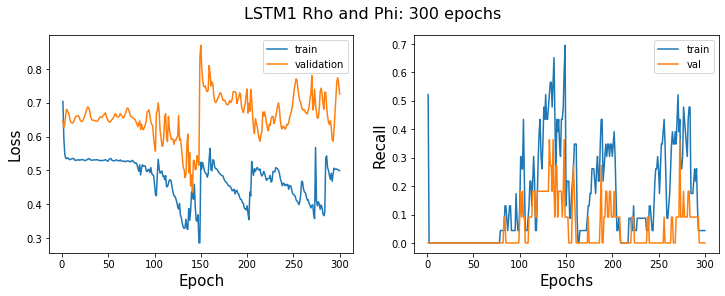

In [148]:
lr_plot(LSTM1_hist,'LSTM1 Rho and Phi: 300 epochs','LSTM1_300epochs.png')

In [149]:
LSTM1_hist2 = model_LSTM1.fit(X_train_rhophi,y_train_rhophi, epochs=300, validation_data=(X_vali_rhophi,y_vali_rhophi))

Epoch 1/300
4/4 [==============================] - 0s 90ms/step - loss: 0.4980 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.7240 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 85ms/step - loss: 0.4961 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.7803 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 96ms/step - lo

Epoch 19/300
4/4 [==============================] - 0s 78ms/step - loss: 0.4746 - accuracy: 0.8039 - true_positives: 4.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 19.0000 - precision: 0.8000 - recall: 0.1739 - val_loss: 0.6811 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 20/300
4/4 [==============================] - 0s 81ms/step - loss: 0.4572 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.7036 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 21/300
4/4 [==============================] - 0s 78ms/step - loss: 0.454

4/4 [==============================] - 0s 87ms/step - loss: 0.3374 - accuracy: 0.8627 - true_positives: 11.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 12.0000 - precision: 0.8462 - recall: 0.4783 - val_loss: 0.6576 - val_accuracy: 0.6857 - val_true_positives: 2.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 9.0000 - val_precision: 0.5000 - val_recall: 0.1818
Epoch 56/300
4/4 [==============================] - 0s 88ms/step - loss: 0.3252 - accuracy: 0.8725 - true_positives: 11.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 12.0000 - precision: 0.9167 - recall: 0.4783 - val_loss: 0.6494 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 57/300
4/4 [==============================] - 0s 94ms/step - loss: 0.3250 - accuracy: 0.8627 - true_positives: 10

4/4 [==============================] - 0s 92ms/step - loss: 0.4573 - accuracy: 0.8137 - true_positives: 4.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 19.0000 - precision: 1.0000 - recall: 0.1739 - val_loss: 0.6859 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 92/300
4/4 [==============================] - 0s 89ms/step - loss: 0.4491 - accuracy: 0.8137 - true_positives: 4.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 19.0000 - precision: 1.0000 - recall: 0.1739 - val_loss: 0.6870 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 93/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4441 - accuracy: 0.8137 - true_posit

4/4 [==============================] - 0s 86ms/step - loss: 0.3640 - accuracy: 0.8725 - true_positives: 10.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 13.0000 - precision: 1.0000 - recall: 0.4348 - val_loss: 0.7994 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 128/300
4/4 [==============================] - 0s 87ms/step - loss: 0.3596 - accuracy: 0.8725 - true_positives: 10.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 13.0000 - precision: 1.0000 - recall: 0.4348 - val_loss: 0.8032 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 129/300
4/4 [==============================] - 0s 86ms/step - loss: 0.3612 - accuracy: 0.8627 - true_po

4/4 [==============================] - 0s 92ms/step - loss: 0.4237 - accuracy: 0.8431 - true_positives: 7.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 16.0000 - precision: 1.0000 - recall: 0.3043 - val_loss: 0.7880 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 164/300
4/4 [==============================] - 0s 96ms/step - loss: 0.4194 - accuracy: 0.8431 - true_positives: 7.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 16.0000 - precision: 1.0000 - recall: 0.3043 - val_loss: 0.7753 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 165/300
4/4 [==============================] - 0s 88ms/step - loss: 0.4164 - accuracy: 0.8431 - true_posit

4/4 [==============================] - 0s 90ms/step - loss: 0.3346 - accuracy: 0.8627 - true_positives: 10.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 13.0000 - precision: 0.9091 - recall: 0.4348 - val_loss: 0.8348 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 200/300
4/4 [==============================] - 0s 85ms/step - loss: 0.3112 - accuracy: 0.8725 - true_positives: 11.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 12.0000 - precision: 0.9167 - recall: 0.4783 - val_loss: 0.7228 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 201/300
4/4 [==============================] - 0s 88ms/step - loss: 0.3230 - accuracy: 0.8529 - true_positives

4/4 [==============================] - 0s 89ms/step - loss: 0.2242 - accuracy: 0.9020 - true_positives: 17.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 6.0000 - precision: 0.8095 - recall: 0.7391 - val_loss: 0.7836 - val_accuracy: 0.7429 - val_true_positives: 4.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 7.0000 - val_precision: 0.6667 - val_recall: 0.3636
Epoch 236/300
4/4 [==============================] - 0s 85ms/step - loss: 0.2385 - accuracy: 0.8824 - true_positives: 17.0000 - true_negatives: 73.0000 - false_positives: 6.0000 - false_negatives: 6.0000 - precision: 0.7391 - recall: 0.7391 - val_loss: 0.5988 - val_accuracy: 0.7429 - val_true_positives: 2.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 9.0000 - val_precision: 1.0000 - val_recall: 0.1818
Epoch 237/300
4/4 [==============================] - 0s 88ms/step - loss: 0.3278 - accuracy: 0.8922 - true_positives

4/4 [==============================] - 0s 87ms/step - loss: 0.5294 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9683 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 272/300
4/4 [==============================] - 0s 90ms/step - loss: 0.5238 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9644 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 273/300
4/4 [==============================] - 0

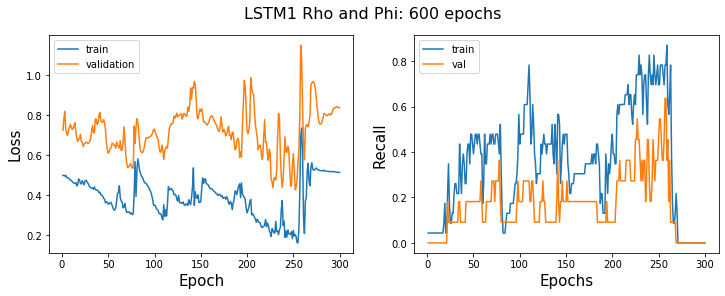

In [150]:
lr_plot(LSTM1_hist2,'LSTM1 Rho and Phi: 600 epochs','LSTM1_600epochs.png')

In [151]:
LSTM1_hist3 = model_LSTM1.fit(X_train_rhophi,y_train_rhophi, epochs=300, validation_data=(X_vali_rhophi,y_vali_rhophi))

Epoch 1/300
4/4 [==============================] - 0s 90ms/step - loss: 0.5132 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8479 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 90ms/step - loss: 0.5123 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8657 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [===========================

4/4 [==============================] - 0s 92ms/step - loss: 0.5077 - accuracy: 0.7745 - true_positives: 1.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 22.0000 - precision: 0.5000 - recall: 0.0435 - val_loss: 0.9346 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/300
4/4 [==============================] - 0s 81ms/step - loss: 0.5057 - accuracy: 0.7843 - true_positives: 2.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 21.0000 - precision: 0.6667 - recall: 0.0870 - val_loss: 0.9349 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/300
4/4 [==============================] - 0s 79ms/step - loss: 0.4948 - accur

Epoch 70/300
4/4 [==============================] - 0s 102ms/step - loss: 0.4540 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.8983 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/300
4/4 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.7745 - true_positives: 1.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 22.0000 - precision: 0.5000 - recall: 0.0435             - 0s 111ms/step - loss: 0.4485 - accuracy: 0.7745 - true_positives: 1.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 22.0000 - precision: 0.5000 - recall: 0.0435 - val_loss: 0.9023 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 2

Epoch 88/300
4/4 [==============================] - 0s 93ms/step - loss: 0.4045 - accuracy: 0.8529 - true_positives: 11.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 12.0000 - precision: 0.7857 - recall: 0.4783 - val_loss: 0.8438 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 89/300
4/4 [==============================] - 0s 94ms/step - loss: 0.3482 - accuracy: 0.8333 - true_positives: 8.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 15.0000 - precision: 0.8000 - recall: 0.3478 - val_loss: 0.9431 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 90/300
4/4 [==============================] - 0s 86ms/step - loss: 0.3927 - accuracy: 0.8137 - true_p

4/4 [==============================] - 0s 99ms/step - loss: 0.4114 - accuracy: 0.8333 - true_positives: 8.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 15.0000 - precision: 0.8000 - recall: 0.3478 - val_loss: 0.5779 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 125/300
4/4 [==============================] - 0s 95ms/step - loss: 0.4028 - accuracy: 0.8431 - true_positives: 9.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 14.0000 - precision: 0.8182 - recall: 0.3913 - val_loss: 0.5715 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 126/300
4/4 [==============================] - 0s 93ms/step - loss: 0.3727 - accuracy: 0.8529 - true_positives: 10

4/4 [==============================] - 0s 96ms/step - loss: 0.3153 - accuracy: 0.9020 - true_positives: 13.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 10.0000 - precision: 1.0000 - recall: 0.5652 - val_loss: 0.5298 - val_accuracy: 0.7143 - val_true_positives: 3.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 8.0000 - val_precision: 0.6000 - val_recall: 0.2727
Epoch 161/300
4/4 [==============================] - 0s 94ms/step - loss: 0.3125 - accuracy: 0.8824 - true_positives: 13.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 10.0000 - precision: 0.8667 - recall: 0.5652 - val_loss: 0.5546 - val_accuracy: 0.7429 - val_true_positives: 3.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 8.0000 - val_precision: 0.7500 - val_recall: 0.2727
Epoch 162/300
4/4 [==============================] - 0s 91ms/step - loss: 0.3017 - accuracy: 0.8824 - true_positiv

4/4 [==============================] - 0s 96ms/step - loss: 0.3759 - accuracy: 0.8431 - true_positives: 10.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 13.0000 - precision: 0.7692 - recall: 0.4348 - val_loss: 0.6956 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 197/300
4/4 [==============================] - 0s 91ms/step - loss: 0.3733 - accuracy: 0.8333 - true_positives: 6.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 17.0000 - precision: 1.0000 - recall: 0.2609 - val_loss: 0.6629 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 198/300
4/4 [==============================] - 0s 92ms/step - loss: 0.3791 - accuracy: 0.8235 - true_positi

4/4 [==============================] - 0s 88ms/step - loss: 0.2155 - accuracy: 0.9412 - true_positives: 17.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 6.0000 - precision: 1.0000 - recall: 0.7391 - val_loss: 0.6504 - val_accuracy: 0.7143 - val_true_positives: 3.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 8.0000 - val_precision: 0.6000 - val_recall: 0.2727
Epoch 233/300
4/4 [==============================] - 0s 91ms/step - loss: 0.2371 - accuracy: 0.9314 - true_positives: 17.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 6.0000 - precision: 0.9444 - recall: 0.7391 - val_loss: 0.7607 - val_accuracy: 0.6857 - val_true_positives: 2.0000 - val_true_negatives: 22.0000 - val_false_positives: 2.0000 - val_false_negatives: 9.0000 - val_precision: 0.5000 - val_recall: 0.1818
Epoch 234/300
4/4 [==============================] - 0s 90ms/step - loss: 0.4281 - accuracy: 0.8235 - true_positives

4/4 [==============================] - 0s 89ms/step - loss: 0.2346 - accuracy: 0.9412 - true_positives: 20.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 3.0000 - precision: 0.8696 - recall: 0.8696 - val_loss: 0.5951 - val_accuracy: 0.6571 - val_true_positives: 2.0000 - val_true_negatives: 21.0000 - val_false_positives: 3.0000 - val_false_negatives: 9.0000 - val_precision: 0.4000 - val_recall: 0.1818
Epoch 269/300
4/4 [==============================] - 0s 92ms/step - loss: 0.2229 - accuracy: 0.9412 - true_positives: 19.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 4.0000 - precision: 0.9048 - recall: 0.8261 - val_loss: 0.6101 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 270/300
4/4 [==============================] - 0s 88ms/step - loss: 0.2221 - accuracy: 0.9314 - true_positives: 18

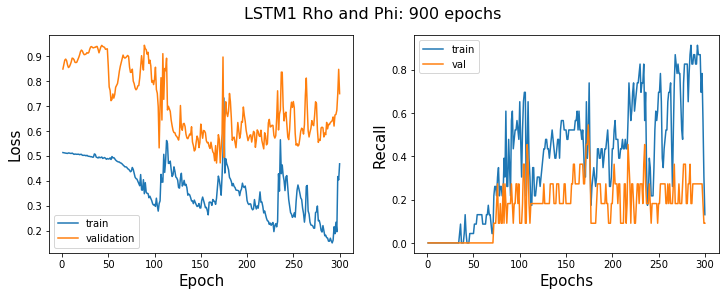

In [152]:
lr_plot(LSTM1_hist3,'LSTM1 Rho and Phi: 900 epochs','LSTM1_900epochs.png')

**I think this model may have an exploding gradient issue even though it is an LSTM. the lossand performance is supper erratice even after 1200 epocs. and now, it seems to be over fitting (training loss going down, validation loss going up)**

**Exploding gradient can be fixed by useing less layers, but my architecture is already pretty shallow.
lets try with some drop out to fix this over fitting,  and more neurons to maybe give the model more to learn with out adding depth.**

In [278]:

model_LSTM2 = keras.Sequential()
model_LSTM2.add(keras.layers.LSTM(100, input_shape=(206, 2), return_sequences=True))
model_LSTM2.add(Dropout(.5))
model_LSTM2.add(keras.layers.LSTM(100, return_sequences=False))
model_LSTM2.add(keras.layers.Dense(1, activation='sigmoid'))
model_LSTM2.compile(optimizer='adam',
              loss='binary_crossentropy',metrics=metrics1)

In [279]:
model_LSTM2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 206, 100)          41200     
_________________________________________________________________
dropout (Dropout)            (None, 206, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 121,701
Trainable params: 121,701
Non-trainable params: 0
_________________________________________________________________


In [166]:
LSTM2_hist = model_LSTM2.fit(X_train_rhophi,y_train_rhophi, epochs=300, validation_data=(X_vali_rhophi,y_vali_rhophi))

Epoch 1/300
4/4 [==============================] - 2s 421ms/step - loss: 0.5950 - accuracy: 0.6765 - true_positives: 4.0000 - true_negatives: 65.0000 - false_positives: 14.0000 - false_negatives: 19.0000 - precision: 0.2222 - recall: 0.1739 - val_loss: 0.7199 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 1s 152ms/step - loss: 0.5648 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6835 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 1s 155

4/4 [==============================] - 1s 164ms/step - loss: 0.5180 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6909 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/300
4/4 [==============================] - 1s 168ms/step - loss: 0.5287 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6949 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/300
4/4 [==============================] - 1

4/4 [==============================] - 1s 175ms/step - loss: 0.5271 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6539 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 70/300
4/4 [==============================] - 1s 170ms/step - loss: 0.5366 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6463 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 71/300
4/4 [==============================] - 1

4/4 [==============================] - 1s 174ms/step - loss: 0.5146 - accuracy: 0.7843 - true_positives: 2.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 21.0000 - precision: 0.6667 - recall: 0.0870 - val_loss: 0.7132 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 104/300
4/4 [==============================] - 1s 172ms/step - loss: 0.5060 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7276 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 105/300
4/4 [==============================] - 1s 168ms/step -

4/4 [==============================] - 1s 168ms/step - loss: 0.5058 - accuracy: 0.7941 - true_positives: 2.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 21.0000 - precision: 1.0000 - recall: 0.0870 - val_loss: 0.6954 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 138/300
4/4 [==============================] - 1s 166ms/step - loss: 0.4895 - accuracy: 0.7745 - true_positives: 2.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 21.0000 - precision: 0.5000 - recall: 0.0870 - val_loss: 0.6969 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 139/300
4/4 [==============================] - 1s 169ms/step - loss: 0.495

Epoch 155/300
4/4 [==============================] - 1s 167ms/step - loss: 0.4973 - accuracy: 0.7941 - true_positives: 3.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 20.0000 - precision: 0.7500 - recall: 0.1304 - val_loss: 0.7088 - val_accuracy: 0.7143 - val_true_positives: 1.0000 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 10.0000 - val_precision: 1.0000 - val_recall: 0.0909
Epoch 156/300
4/4 [==============================] - 1s 168ms/step - loss: 0.4989 - accuracy: 0.7941 - true_positives: 4.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 19.0000 - precision: 0.6667 - recall: 0.1739 - val_loss: 0.6562 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 157/300
4/4 [==============================] - 1s 168ms/step - loss: 0.5240 - accuracy: 0.76

Epoch 173/300
4/4 [==============================] - 1s 166ms/step - loss: 0.5098 - accuracy: 0.7843 - true_positives: 2.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 21.0000 - precision: 0.6667 - recall: 0.0870 - val_loss: 0.7185 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 174/300
4/4 [==============================] - 1s 165ms/step - loss: 0.4921 - accuracy: 0.7941 - true_positives: 2.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 21.0000 - precision: 1.0000 - recall: 0.0870 - val_loss: 0.6852 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 175/300
4/4 [==============================] - 1s 170ms/step

Epoch 191/300
4/4 [==============================] - 1s 177ms/step - loss: 0.4649 - accuracy: 0.8039 - true_positives: 7.0000 - true_negatives: 75.0000 - false_positives: 4.0000 - false_negatives: 16.0000 - precision: 0.6364 - recall: 0.3043 - val_loss: 0.5647 - val_accuracy: 0.7429 - val_true_positives: 3.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 8.0000 - val_precision: 0.7500 - val_recall: 0.2727
Epoch 192/300
4/4 [==============================] - 1s 180ms/step - loss: 0.4169 - accuracy: 0.8627 - true_positives: 11.0000 - true_negatives: 77.0000 - false_positives: 2.0000 - false_negatives: 12.0000 - precision: 0.8462 - recall: 0.4783 - val_loss: 0.8405 - val_accuracy: 0.5714 - val_true_positives: 2.0000 - val_true_negatives: 18.0000 - val_false_positives: 6.0000 - val_false_negatives: 9.0000 - val_precision: 0.2500 - val_recall: 0.1818
Epoch 193/300
4/4 [==============================] - 1s 177ms/step - loss: 0.5804 - accuracy: 0.7353 - 

Epoch 226/300
4/4 [==============================] - 1s 190ms/step - loss: 0.4984 - accuracy: 0.7941 - true_positives: 2.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 21.0000 - precision: 1.0000 - recall: 0.0870 - val_loss: 0.7093 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 227/300
4/4 [==============================] - 1s 180ms/step - loss: 0.5179 - accuracy: 0.7549 - true_positives: 6.0000 - true_negatives: 71.0000 - false_positives: 8.0000 - false_negatives: 17.0000 - precision: 0.4286 - recall: 0.2609 - val_loss: 0.7098 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 228/300
4/4 [==============================] - 1s 198ms/step - loss:

Epoch 244/300
4/4 [==============================] - 1s 173ms/step - loss: 0.4807 - accuracy: 0.8039 - true_positives: 3.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 20.0000 - precision: 1.0000 - recall: 0.1304 - val_loss: 0.7370 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 245/300
4/4 [==============================] - 1s 191ms/step - loss: 0.4757 - accuracy: 0.8039 - true_positives: 3.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 20.0000 - precision: 1.0000 - recall: 0.1304 - val_loss: 0.6739 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 246/300
4/4 [==============================] - 1s 172ms/step - loss: 0.4609 - accuracy: 0

4/4 [==============================] - 1s 200ms/step - loss: 0.4431 - accuracy: 0.8235 - true_positives: 8.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 15.0000 - precision: 0.7273 - recall: 0.3478 - val_loss: 0.6572 - val_accuracy: 0.7429 - val_true_positives: 3.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 8.0000 - val_precision: 0.7500 - val_recall: 0.2727
Epoch 263/300
4/4 [==============================] - 1s 202ms/step - loss: 0.4454 - accuracy: 0.8235 - true_positives: 8.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 15.0000 - precision: 0.7273 - recall: 0.3478 - val_loss: 0.6486 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 264/300
4/4 [==============================] - 1s 202ms/step - loss: 0.4386 - accuracy: 0.8333 - true_positives:

Epoch 298/300
4/4 [==============================] - 1s 195ms/step - loss: 0.3544 - accuracy: 0.8627 - true_positives: 12.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 11.0000 - precision: 0.8000 - recall: 0.5217 - val_loss: 0.4617 - val_accuracy: 0.7429 - val_true_positives: 3.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 8.0000 - val_precision: 0.7500 - val_recall: 0.2727
Epoch 299/300
4/4 [==============================] - 1s 197ms/step - loss: 0.4146 - accuracy: 0.8235 - true_positives: 6.0000 - true_negatives: 78.0000 - false_positives: 1.0000 - false_negatives: 17.0000 - precision: 0.8571 - recall: 0.2609 - val_loss: 0.5807 - val_accuracy: 0.7143 - val_true_positives: 2.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 9.0000 - val_precision: 0.6667 - val_recall: 0.1818
Epoch 300/300
4/4 [==============================] - 1s 188ms/step - loss: 0.4214 - accuracy: 0.7941 - 

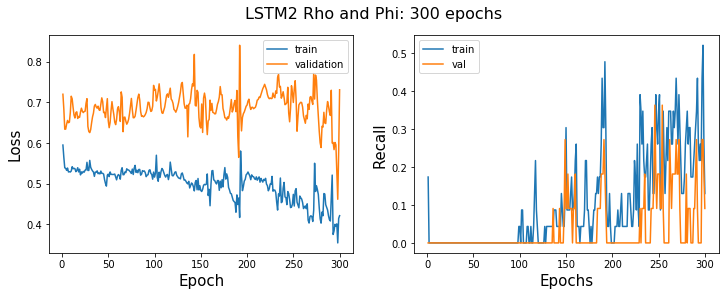

In [167]:
lr_plot(LSTM2_hist,'LSTM2 Rho and Phi: 300 epochs','LSTM2_300epochs.png')

In [168]:
LSTM2_hist2 = model_LSTM2.fit(X_train_rhophi,y_train_rhophi, epochs=300, validation_data=(X_vali_rhophi,y_vali_rhophi))

Epoch 1/300
4/4 [==============================] - 1s 144ms/step - loss: 0.5338 - accuracy: 0.7745 - true_positives: 3.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 20.0000 - precision: 0.5000 - recall: 0.1304 - val_loss: 0.9265 - val_accuracy: 0.6571 - val_true_positives: 0.0000e+00 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 1s 139ms/step - loss: 0.5828 - accuracy: 0.7647 - true_positives: 2.0000 - true_negatives: 76.0000 - false_positives: 3.0000 - false_negatives: 21.0000 - precision: 0.4000 - recall: 0.0870 - val_loss: 0.6781 - val_accuracy: 0.6857 - val_true_positives: 1.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 10.0000 - val_precision: 0.5000 - val_recall: 0.0909
Epoch 3/300
4/4 [==============================] - 1s 139ms/step - loss: 0.5606 - accuracy: 0.

Epoch 19/300
4/4 [==============================] - 1s 143ms/step - loss: 0.5283 - accuracy: 0.7255 - true_positives: 6.0000 - true_negatives: 68.0000 - false_positives: 11.0000 - false_negatives: 17.0000 - precision: 0.3529 - recall: 0.2609 - val_loss: 0.6552 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 20/300
4/4 [==============================] - 1s 151ms/step - loss: 0.4720 - accuracy: 0.7843 - true_positives: 1.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 22.0000 - precision: 1.0000 - recall: 0.0435 - val_loss: 0.7141 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 21/300
4/4 [==============================] - 1s 153ms/step -

4/4 [==============================] - 1s 167ms/step - loss: 0.5297 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6392 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 54/300
4/4 [==============================] - 1s 169ms/step - loss: 0.5348 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6354 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 55/300
4/4 [==============================] - 1

4/4 [==============================] - 1s 175ms/step - loss: 0.5233 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6983 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 88/300
4/4 [==============================] - 1s 171ms/step - loss: 0.5165 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6876 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 89/300
4/4 [==============================] - 1

4/4 [==============================] - 1s 169ms/step - loss: 0.5301 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6490 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 122/300
4/4 [==============================] - 1s 170ms/step - loss: 0.5308 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6453 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 123/300
4/4 [==============================] -

4/4 [==============================] - 1s 166ms/step - loss: 0.5335 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6453 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 156/300
4/4 [==============================] - 1s 169ms/step - loss: 0.5391 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6387 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 157/300
4/4 [==============================] -

4/4 [==============================] - 1s 170ms/step - loss: 0.5398 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6562 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 190/300
4/4 [==============================] - 1s 167ms/step - loss: 0.5313 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6494 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 191/300
4/4 [==============================] -

4/4 [==============================] - 1s 169ms/step - loss: 0.5306 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6444 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 224/300
4/4 [==============================] - 1s 169ms/step - loss: 0.5379 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6485 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 225/300
4/4 [==============================] -

4/4 [==============================] - 1s 170ms/step - loss: 0.5259 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6674 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 258/300
4/4 [==============================] - 1s 169ms/step - loss: 0.5316 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6745 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 259/300
4/4 [==============================] -

4/4 [==============================] - 1s 169ms/step - loss: 0.5306 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6668 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 292/300
4/4 [==============================] - 1s 174ms/step - loss: 0.5406 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6653 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 293/300
4/4 [==============================] -

**Although the drop out seemed to help with over fitting this model is suffereing from instable gradient still.**

# SimpleWave
The LSTM perfomed very poorly but the 1d cnn has performed the best so far. To try and replicate the "long term memory" effects that an LSTM uses to find patterns in longer periods of time, I will use dilation in my convolution layers of my CNN so as to artificial increat the size of my filteres with dilation.<br>

>Dilation: A dilated convolution is a convolution where the filter is applied over an area larger than its length by skipping input values. It is
equivalent to a convolution with a **larger filter** derived from the
original filter by dilating it with zeros but is significantly **more
efficient.**<br>

By using dilation the model gets a better global picture of each sample to capture more contextual information by looking at different segments of the time series.  There is also the benefit of faster run time.

In [353]:
'''model_wave1 = Sequential()

model_wave1.add(keras.layers.InputLayer(input_shape=[None,2]))
#this is where i tell it to double the dilation on each layer
for rate in (1,2,4,8) * 2:
    model_wave1.add(keras.layers.Conv1D(filters=20, kernel_size=2,activation='relu',padding='causal',dilation_rate=rate))
model_wave1.add(keras.layers.Conv1D(filters=10,kernel_size=1))
model_wave1.add(keras.layers.Conv1D(filters=1,kernel_size=1))
#model_wave1.add(Dense(1, activation='sigmoid'))'''

I am modeling my achitecture here after an achritecture developed by DeepMind researches called WaveNet, but I am making much shallower. I also change the output layer to a single neuron for my binary clasification. WaveNet was used for speach recognition so it had many neurons in it final layer. thus, SimpleWave

In [438]:
model_wave1 = Sequential()

model_wave1.add(Conv1D(filters=10, kernel_size=2, activation='relu', input_shape=(206,2)))
model_wave1.add(Conv1D(filters=20, kernel_size=2,activation='relu',padding='causal',dilation_rate=1))
model_wave1.add(Conv1D(filters=30, kernel_size=2,activation='relu',padding='causal',dilation_rate=2))
model_wave1.add(Conv1D(filters=40, kernel_size=2,activation='relu',padding='causal',dilation_rate=4))
model_wave1.add(Conv1D(filters=50, kernel_size=2,activation='relu',padding='causal',dilation_rate=8))
model_wave1.add(Conv1D(filters=20, kernel_size=2,activation='relu',padding='causal',dilation_rate=16))
model_wave1.add(Flatten())
model_wave1.add(Dense(1, activation='sigmoid'))

In [439]:
model_wave1.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics1)

In [440]:
model_wave1.summary()

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_494 (Conv1D)          (None, 205, 10)           50        
_________________________________________________________________
conv1d_495 (Conv1D)          (None, 205, 20)           420       
_________________________________________________________________
conv1d_496 (Conv1D)          (None, 205, 30)           1230      
_________________________________________________________________
conv1d_497 (Conv1D)          (None, 205, 40)           2440      
_________________________________________________________________
conv1d_498 (Conv1D)          (None, 205, 50)           4050      
_________________________________________________________________
conv1d_499 (Conv1D)          (None, 205, 20)           2020      
_________________________________________________________________
flatten_21 (Flatten)         (None, 4100)            

***NOTE: the best SimpleWave has been saved below so you can reload as appoes to re fitting the model***

In [441]:
wave1_hist = model_wave1.fit(X_train_rhophi,y_train_rhophi, epochs=300, validation_data=(X_vali_rhophi,y_vali_rhophi))

Epoch 1/300
4/4 [==============================] - 1s 150ms/step - loss: 0.6593 - accuracy: 0.5980 - true_positives: 7.0000 - true_negatives: 54.0000 - false_positives: 25.0000 - false_negatives: 16.0000 - precision: 0.2188 - recall: 0.3043 - val_loss: 0.6286 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 18ms/step - loss: 0.5287 - accuracy: 0.7745 - true_positives: 0.0000e+00 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 23.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7069 - val_accuracy: 0.6857 - val_true_positives: 0.0000e+00 - val_true_negatives: 24.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 15ms/step - loss: 0.0304 - accuracy: 0.9902 - true_positives: 22.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000 - precision: 1.0000 - recall: 0.9565 - val_loss: 0.2033 - val_accuracy: 0.8857 - val_true_positives: 8.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 3.0000 - val_precision: 0.8889 - val_recall: 0.7273
Epoch 37/300
4/4 [==============================] - 0s 20ms/step - loss: 0.0216 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9714 - val_true_positives: 11.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 0.0000e+00 - val_precision: 0.9167 - val_recall: 1.0000
Epoch 38/300
4/4 [==============================] - 0s 19ms/step - loss: 0.0225 - accuracy: 1.0000 - tru

4/4 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1292 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 73/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1462 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 74/300
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - tru

Epoch 90/300
4/4 [==============================] - 0s 17ms/step - loss: 7.5554e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1485 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 91/300
4/4 [==============================] - 0s 15ms/step - loss: 7.2836e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1511 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 92/300
4/4 [==============================] - 0s 15ms/step - loss: 7.1653e-0

Epoch 108/300
4/4 [==============================] - 0s 16ms/step - loss: 5.3800e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1502 - val_accuracy: 0.9143 - val_true_positives: 9.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 2.0000 - val_precision: 0.9000 - val_recall: 0.8182
Epoch 109/300
4/4 [==============================] - 0s 16ms/step - loss: 4.7695e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1410 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 110/300
4/4 [==============================] - 0s 15ms/step - loss: 4.6805e

Epoch 126/300
4/4 [==============================] - 0s 15ms/step - loss: 3.3480e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1305 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 127/300
4/4 [==============================] - 0s 15ms/step - loss: 3.2468e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1368 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 128/300
4/4 [==============================] - 0s 15ms/step - loss: 3.2765

Epoch 144/300
4/4 [==============================] - 0s 15ms/step - loss: 2.4401e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1262 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 145/300
4/4 [==============================] - 0s 15ms/step - loss: 2.2276e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1381 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 146/300
4/4 [==============================] - 0s 15ms/step - loss: 2.4579

Epoch 162/300
4/4 [==============================] - 0s 14ms/step - loss: 1.7772e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1220 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 163/300
4/4 [==============================] - 0s 16ms/step - loss: 1.7299e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1233 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 164/300
4/4 [==============================] - 0s 15ms/step - loss: 1.6954

Epoch 180/300
4/4 [==============================] - 0s 16ms/step - loss: 1.3641e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1186 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 181/300
4/4 [==============================] - 0s 16ms/step - loss: 1.3390e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1168 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 182/300
4/4 [==============================] - 0s 15ms/step - loss: 1.3111

Epoch 198/300
4/4 [==============================] - 0s 15ms/step - loss: 1.0413e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1159 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 199/300
4/4 [==============================] - 0s 16ms/step - loss: 1.0831e-04 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1160 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 200/300
4/4 [==============================] - 0s 15ms/step - loss: 1.0165

Epoch 216/300
4/4 [==============================] - 0s 16ms/step - loss: 8.5571e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1130 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 217/300
4/4 [==============================] - 0s 15ms/step - loss: 8.4187e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1109 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 218/300
4/4 [==============================] - 0s 15ms/step - loss: 8.2892

Epoch 234/300
4/4 [==============================] - 0s 16ms/step - loss: 6.8228e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1052 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 235/300
4/4 [==============================] - 0s 16ms/step - loss: 6.5571e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1008 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 236/300
4/4 [==============================] - 0s 15ms/step - loss: 7.8298

Epoch 252/300
4/4 [==============================] - 0s 15ms/step - loss: 5.7772e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 253/300
4/4 [==============================] - 0s 15ms/step - loss: 5.7632e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1011 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 254/300
4/4 [==============================] - 0s 15ms/step - loss: 5.4759

Epoch 270/300
4/4 [==============================] - 0s 15ms/step - loss: 4.5790e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0948 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 271/300
4/4 [==============================] - 0s 15ms/step - loss: 4.5479e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0946 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 272/300
4/4 [==============================] - 0s 15ms/step - loss: 4.5056

Epoch 288/300
4/4 [==============================] - 0s 16ms/step - loss: 3.9033e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0921 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 289/300
4/4 [==============================] - 0s 16ms/step - loss: 3.8518e-05 - accuracy: 1.0000 - true_positives: 23.0000 - true_negatives: 79.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0915 - val_accuracy: 0.9429 - val_true_positives: 10.0000 - val_true_negatives: 23.0000 - val_false_positives: 1.0000 - val_false_negatives: 1.0000 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 290/300
4/4 [==============================] - 0s 16ms/step - loss: 3.7989

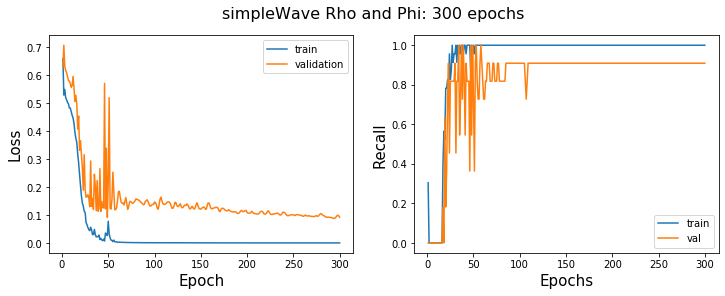

In [442]:
lr_plot(wave1_hist,'simpleWave Rho and Phi: 300 epochs','simpleWave_300epochs_2.png')

In [445]:
model_wave1.save('../models/simpleWave.h5')

### This looks great! 
Both the SimpleWave and 1d cnn perform pretty well. Lets compair them

# compairing models

### read in hold out data and preprocess

In [39]:
# grabbing hold out data
holdout_raw,meta = arff.loadarff('../data/Epilepsy_TEST.arff')

In [40]:
holdout_pd = pd.DataFrame(holdout_raw)

In [41]:
#changing labels to binary
holdout_pd['label_binary'] = np.where(holdout_pd['activity']==b'EPILEPSY',1,0)

In [42]:
#preprocessing x in the same way as training data
rho_phi = df_to_rho_phi(holdout_pd)

../src/HAR_functions.py:37: RuntimeWarning: divide by zero encountered in true_divide
  


In [43]:
rho_phi.shape

(138, 206, 2)

In [44]:
y_hold = holdout_pd['label_binary'].values

### explore thresholds

In [ ]:
model_wave1 = keras.models.load_model('../models/simpleWave.h5')

In [152]:
#probability predictions for simplewave
proba = model_wave1.predict_proba(rho_phi)

In [176]:
model_CNN1d = keras.models.load_model('../models/CNN1d.h5')

In [177]:
#probability predictions for 1d cnn
proba2 = model_CNN1d.predict_proba(rho_phi)

**roc for best models**

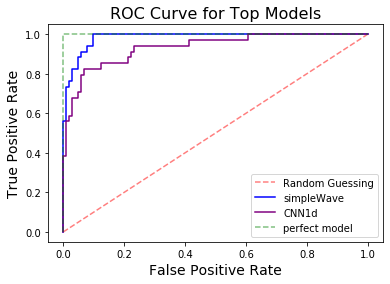

In [244]:
ROC(y_hold,proba,proba2,'simpleWave', 'CNN1d')

**over all it looks like somple wave is a better model. But, since there is a large cost disparity between false negatives and false positive when it comes to siezure detection,  I will examine the models with different positive prediction thresholds to optimize them for this cost difference.
I chose these costs becasue A False positives is annoying if it happens too much.  But being able to classify a true positive  is  of utmost  concern**
>cost of FP : -5<br>
cost of TP L: 95 (or 100-5)


In [197]:
model_d = {'simpleWave':model_wave1, '1D CNN':model_CNN1d}

Price of False Positive:-5
Price of False Negative:0
Price of True Positive:95
Price of True Negative:0


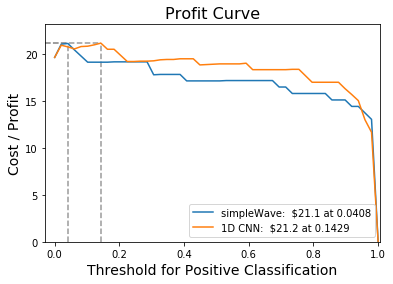

In [253]:
profit_thresh = profit_curve(model_d,rho_phi,y_hold)


In [45]:
#simpleWave = keras.models.load_model('../models/simpleWave.h5')

**Now lets look at a confusion matrix with custom theshold found from profit curve**

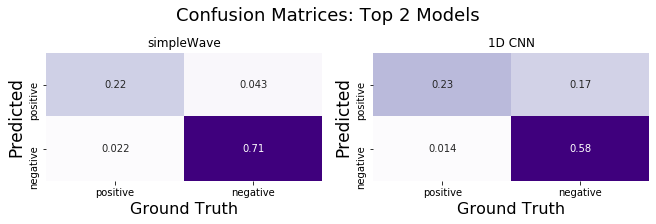

In [306]:

custom_cm2(y_hold,proba,proba2,.0408,.1429,'simpleWave','1D CNN')

# conclusion

Going by the ROC curve the simple wave out performs, but when applying cost/benifit to out comes, they can perform equally well. 1d cnn may have a lowere accuray (tp+tn) but it has a lower false negative which is something we really dont want to  have in this situation. 